# Gaussian mixture models from scratch
Creating a GMM using pytorch based of blog https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

In [18]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from SimPEG import (
    maps,
    data,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import copy
from pymatsolver import PardisoSolver
from scipy.stats import norm
import discretize
import torch
from einops import rearrange
from torch import nn
from torchvision.ops import StochasticDepth
from typing import List, Iterable

First lets use a known dataset which is the Iris dataset

In [97]:
iris = datasets.load_iris()
X = iris.data

# convert to pytorch
X = torch.from_numpy(X)
print(X.shape, X[0, :])

torch.Size([150, 4]) tensor([5.1000, 3.5000, 1.4000, 0.2000])


Use pytorch to impliment the Gaussian denisty equation:
    
$$
\mathcal{N}(\mathbf{x}|\mu, \Sigma) = \frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma|^{\frac{1}{2}}}e^{\left( -\frac{1}{2}(\mathbf{x} - \mu)^T \Sigma^{-1}(\mathbf{x} - \mu) \right)}
$$

- $\mathbf{x}$ is our data
- D is the number of dimensions of each data point.
- $\mu$ is the mean with dimensions 1 x 3
- $\Sigma$ is the covariance with dimensions 3 x 3.

In [19]:
def torch_gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return torch.diagonal(1 / ((2 * np.pi) ** (n / 2) * torch.linalg.det(cov) ** 0.5) * np.exp(-0.5 * torch.matmul(torch.matmul(diff.T, torch.linalg.inv(cov)), diff)))

In [175]:
# x0 = torch.from_numpy(np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]]))

mesh = discretize.TensorMesh.readUBC(r"C:\Users\johnk\Documents\git\ts\PGI\global_mesh.txt")
x0 = torch.from_numpy(discretize.TreeMesh.readModelUBC(mesh, r"C:\Users\johnk\Documents\git\ts\PGI\dc_res_40__14.mod")).view(1, -1)
x0=x0[x0 > 1e-8].view(1, -1)
mu = torch.mean(x0, axis=0)
# print((x0 - mu).T, x0 - mu)
cov = torch.matmul((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)
print(cov.shape, x0.shape, mu.shape, (x0 - mu).T.shape)
y = torch_gaussian(x0, mu=mu, cov=cov)
# y
print(y)
plt.plot(y)

torch.Size([13651, 13651]) torch.Size([1, 13651]) torch.Size([13651]) torch.Size([13651, 1])


OverflowError: (34, 'Result too large')

## Maximization algorithm

**Step 1: Initialization Step** 

Use k-means to initialize our parameters:
- Proportions $\pi_k$
- Means $\mu_k$
- Covariances $\Sigma_k$

In [20]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = torch.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': torch.from_numpy(mu_k[i]),
            'cov_k': torch.eye(X.shape[1])
        })
        
    return clusters

In [99]:
initialize_clusters(X, 3)

C:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[{'pi_k': 0.3333333333333333,
  'mu_k': tensor([6.8500, 3.0737, 5.7421, 2.0711]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])},
 {'pi_k': 0.3333333333333333,
  'mu_k': tensor([5.0060, 3.4280, 1.4620, 0.2460]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])},
 {'pi_k': 0.3333333333333333,
  'mu_k': tensor([5.9016, 2.7484, 4.3935, 1.4339]),
  'cov_k': tensor([[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]])}]

**Step 2: Expectation Step**

$$
\gamma(\mathcal{z}_{nk}) = \frac{\pi_k \mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n|\mu_j, \Sigma_j)}
$$

In [21]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = torch.zeros(N, 1)
    gamma_nk = torch.zeros(N, K)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * torch_gaussian(X, mu_k, cov_k)).ravel()
    
    totals = torch.sum(gamma_nk, 1)
    gamma_nk /= torch.unsqueeze(totals, 1)

**Step 3: Maximation step**

$\gamma(\mathcal{z}_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$ and will define as:

$$
N_k = \sum_{n=1}^N \gamma(z_{nk})
$$

The updated parameters are now:

$$
\pi_k^* = \frac{N_k}{N}
$$

$$
\mu_k^* = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$

$$
\Sigma_k^* = \sum_{n=1}^N \gamma(z_{nk})(\mathbf{x}_n
- \mu_k)(\mathbf{x}_n - \mu_k)^T
$$

In [22]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = torch.unsqueeze(gamma_nk[:, k], 1)
        N_k = torch.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = torch.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

**Calculate the log likelihood**

$$
ln (p(\mathbf{X})) = \sum_{n=1}^N ln \sum_{k-1}^K \pi_k \mathcal{N}(\mathbf{x}_n|\mu_k, \Sigma_k)
$$

Part of this is already calculated. Need to pass this along

In [23]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = torch.log(totals)
    return torch.sum(sample_likelihoods), sample_likelihoods

**All together now!**

Create a method executing the proceedure for training our GMM and examine the log-likelihoods

In [24]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = torch.zeros(n_epochs, )
    scores = torch.zeros(X.shape[0], n_clusters)
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'],
                'cov_k': cluster['cov_k']
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = torch.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [104]:
torch.set_default_dtype(torch.float64)
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

C:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch:  1 Likelihood:  tensor(-727.7881)
Epoch:  2 Likelihood:  tensor(-229.3310)
Epoch:  3 Likelihood:  tensor(-199.7481)
Epoch:  4 Likelihood:  tensor(-195.7389)
Epoch:  5 Likelihood:  tensor(-192.3961)
Epoch:  6 Likelihood:  tensor(-189.9948)
Epoch:  7 Likelihood:  tensor(-188.3670)
Epoch:  8 Likelihood:  tensor(-187.1222)
Epoch:  9 Likelihood:  tensor(-185.9689)
Epoch:  10 Likelihood:  tensor(-184.9027)
Epoch:  11 Likelihood:  tensor(-183.9616)
Epoch:  12 Likelihood:  tensor(-183.1230)
Epoch:  13 Likelihood:  tensor(-182.4218)
Epoch:  14 Likelihood:  tensor(-181.8531)
Epoch:  15 Likelihood:  tensor(-181.2745)
Epoch:  16 Likelihood:  tensor(-180.6706)
Epoch:  17 Likelihood:  tensor(-180.3403)
Epoch:  18 Likelihood:  tensor(-180.2333)
Epoch:  19 Likelihood:  tensor(-180.2004)
Epoch:  20 Likelihood:  tensor(-180.1902)
Epoch:  21 Likelihood:  tensor(-180.1870)
Epoch:  22 Likelihood:  tensor(-180.1859)
Epoch:  23 Likelihood:  tensor(-180.1856)
Epoch:  24 Likelihood:  tensor(-180.1855)
E

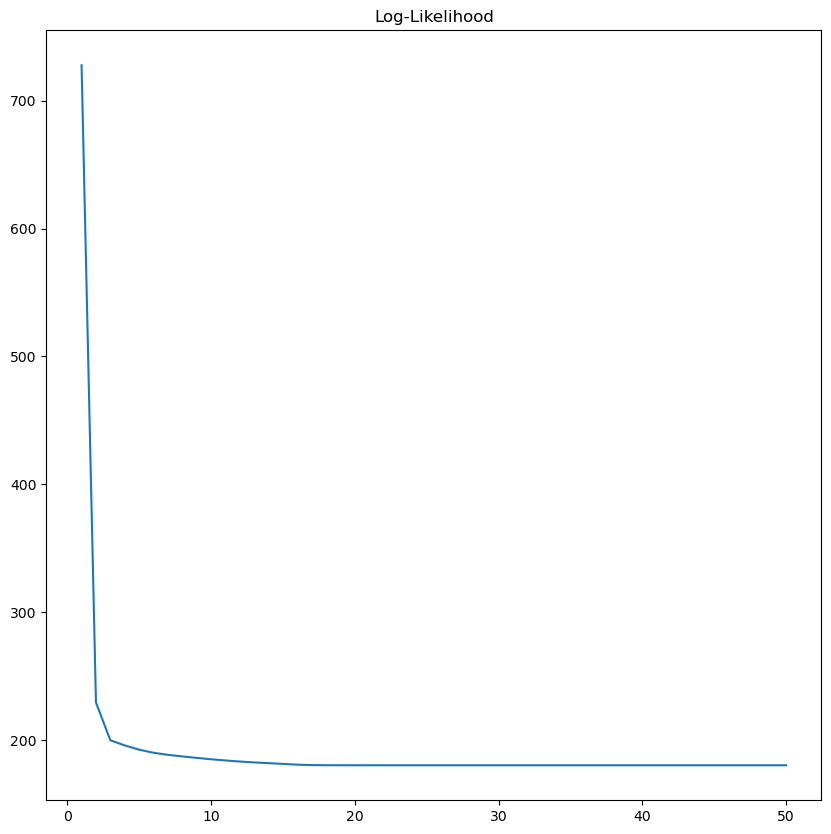

torch.Size([50]) torch.Size([150, 3])


In [135]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), -likelihoods)
plt.show()
print(likelihoods.shape, scores.shape)

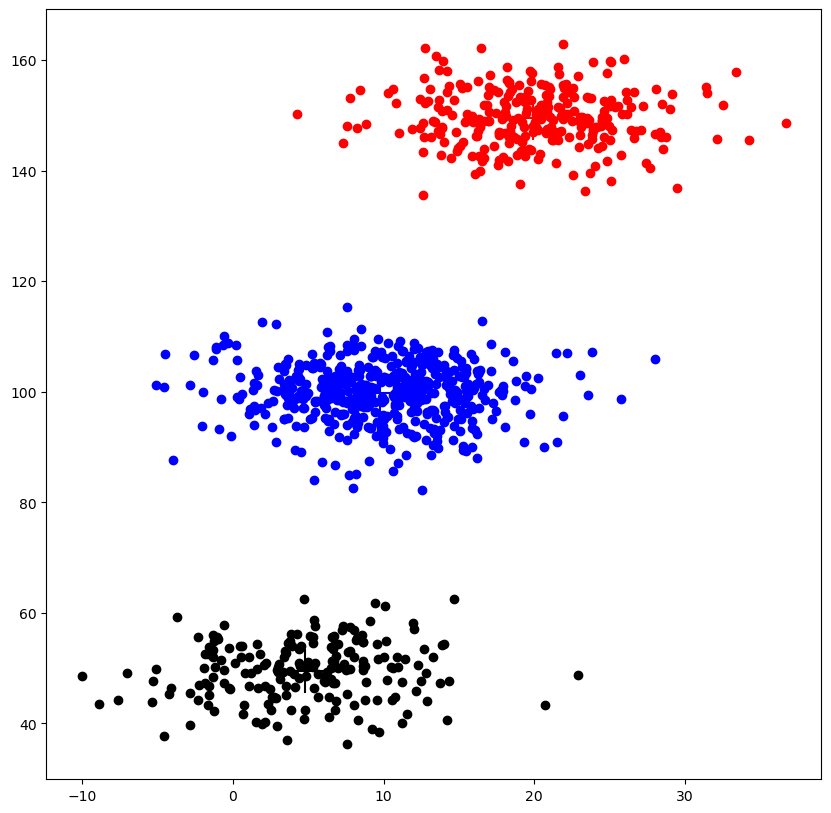

In [31]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black', 'magenta']
    images = []
    
#     for j, clusters in enumerate(history):
    clusters = history[-1]
    j = len(history) - 1
    idx = 0

#     if j % 3 != 0:
#         continue

    plt.cla()

    for cluster in clusters:
        mu = cluster['mu_k']
        cov = cluster['cov_k']

        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
        theta = np.arctan2(vy, vx)

        color = colors.to_rgba(colorset[idx])

#             for cov_factor in range(1, 4):
#                 ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[2]) * cov_factor * 2, height=np.sqrt(eigenvalues[3]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
#                 ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
#                 ax.add_artist(ell)

        ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
        idx += 1

    for i in range(X.shape[0]):
        ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
    # ax.scatter([5.5], [3.25], c='green', marker='o')
    fig.canvas.draw()
        
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#         images.append(image)
    
#     kwargs_write = {'fps':1.0, 'quantizer':'nq'}
#     imageio.mimsave('./gmm.gif', images, fps=1)
#     plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

In [164]:
expectation_step(torch.from_numpy(np.asarray([5.5, 3.25, 2.5, 0.7])).view(1, 4), clusters)
print(np.argmax(gamma_nk))
# # print(likelihoods)
# print(scores[50, :])
# print(scores)
# print(sample_likelihoods)
print(clusters[-1])

tensor(1)
{'pi_k': tensor([0.2992]), 'mu_k': tensor([5.9150, 2.7778, 4.2016, 1.2970]), 'cov_k': tensor([[0.2753, 0.0969, 0.1847, 0.0544],
        [0.0969, 0.0926, 0.0911, 0.0430],
        [0.1847, 0.0911, 0.2006, 0.0610],
        [0.0544, 0.0430, 0.0610, 0.0320]])}


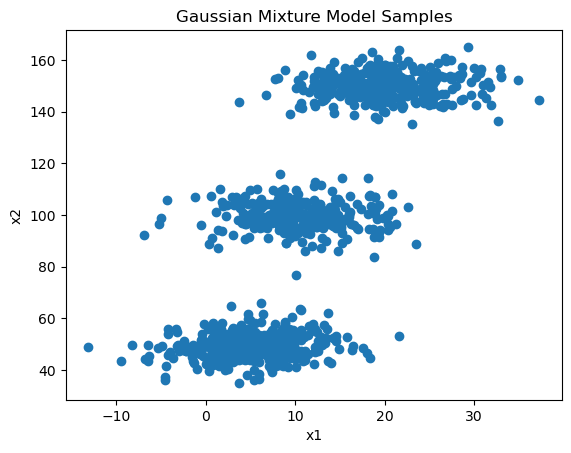

In [71]:
# This is a sample Python script.

# Press Shift+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.
import numpy as np
import matplotlib.pyplot as plt

def normal(value):
    return 1/np.sqrt(2*np.pi)* np.exp(-value**2/2)

def gaussian(value, mean, variance):
    return 1/(np.sqrt(2*np.pi)*variance) * np.exp(-1/(2*variance**2)*(value-mean)**2)

def inv_sigmoid(value):
    return np.log(value/(1-value))

def gmm(value, pis, means, variances):
    density = np.zeros(value.shape)
    for i, mean in enumerate(means):
        density += pis[i]/np.sqrt(2*np.pi)/variances[i] * np.exp(-1/(2*variances[i]**2)*(value-mean)**2)
    return density


mus = [np.array([5, 50]), np.array([10, 100]), np.array([20, 150])]
covs = [np.array([[5, 0], [0, 5]]), np.array([[5, 0], [0, 5]]), np.array([[5, 0], [0, 5]])]

# mus = [np.array([0, 1]), np.array([7, 10]), np.array([-3, -3])]
# covs = [np.array([[1, 2], [2, 1]]), np.array([[1, 0], [0, 1]]), np.array([[2, 1], [1, 0.3]])]

pis = np.array([1/3, 1/3, 1/3])
acc_pis = [np.sum(pis[:i]) for i in range(1, len(pis) + 1)]
assert np.isclose(acc_pis[-1], 1)

n = 1000
samples = []

for i in range(n):
    # sample uniform
    r = np.random.uniform(0, 1)
    # select gaussian
    k = 0
    for i, threshold in enumerate(acc_pis):
        if r < threshold:
            k = i
            break

    selected_mu = mus[k]
    selected_cov = covs[k]

    # sample from selected gaussian
    lambda_, gamma_ = np.linalg.eig(selected_cov)

    dimensions = len(lambda_)
    # sampling from normal distribution
    y_s = np.random.uniform(0, 1, size=(dimensions * 1, 3))
    x_normal = np.mean(inv_sigmoid(y_s), axis=1).reshape((-1, dimensions))
    # transforming into multivariate distribution
    x_multi = (x_normal * lambda_) @ gamma_ + selected_mu
    samples.append(x_multi.tolist()[0])

fig = plt.figure()
samples = np.array(samples)
plt.scatter(samples[:, 0], samples[:, 1])
plt.title('Gaussian Mixture Model Samples')
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()
# fig.savefig('../../Portfolio/samples_gmm_2.png')


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


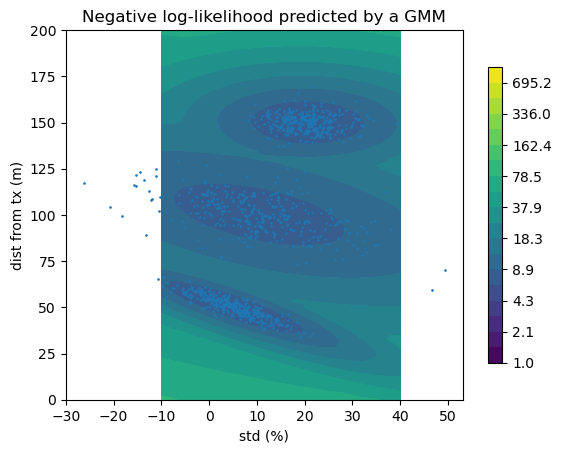

In [64]:
"""
=========================================
Density Estimation for a Gaussian mixture
=========================================

Plot the density estimation of a mixture of two Gaussians. Data is
generated from two Gaussians with different centers and covariance
matrices.

"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# concatenate the two datasets into the final training set
X_train = samples

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=3, covariance_type="full")
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-10.0, 40.0)
y = np.linspace(0.0, 200.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contourf(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 20)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.xlabel('std (%)')
plt.ylabel('dist from tx (m)')
plt.show()

## Try out pytorch version

In [72]:
torch.set_default_dtype(torch.float64)
n_clusters = 3
n_epochs = 50
X_train = torch.from_numpy(samples)

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X_train, n_clusters, n_epochs)

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\johnk\AppData\Local\Temp\ipykernel_12856\2388624634.py:4: RuntimeWarning: overflow encountered in exp
  return torch.diagonal(1 / ((2 * np.pi) ** (n / 2) * torch.linalg.det(cov) ** 0.5) * np.exp(-0.5 * torch.matmul(torch.matmul(diff.T, torch.linalg.inv(cov)), diff)))


Epoch:  1 Likelihood:  tensor(-29863.3918)
Epoch:  2 Likelihood:  tensor(-7221.7945)
Epoch:  3 Likelihood:  tensor(-7221.7945)
Epoch:  4 Likelihood:  tensor(-7221.7945)
Epoch:  5 Likelihood:  tensor(-7221.7945)
Epoch:  6 Likelihood:  tensor(-7221.7945)
Epoch:  7 Likelihood:  tensor(-7221.7945)
Epoch:  8 Likelihood:  tensor(-7221.7945)
Epoch:  9 Likelihood:  tensor(-7221.7945)
Epoch:  10 Likelihood:  tensor(-7221.7945)
Epoch:  11 Likelihood:  tensor(-7221.7945)
Epoch:  12 Likelihood:  tensor(-7221.7945)
Epoch:  13 Likelihood:  tensor(-7221.7945)
Epoch:  14 Likelihood:  tensor(-7221.7945)
Epoch:  15 Likelihood:  tensor(-7221.7945)
Epoch:  16 Likelihood:  tensor(-7221.7945)
Epoch:  17 Likelihood:  tensor(-7221.7945)
Epoch:  18 Likelihood:  tensor(-7221.7945)
Epoch:  19 Likelihood:  tensor(-7221.7945)
Epoch:  20 Likelihood:  tensor(-7221.7945)
Epoch:  21 Likelihood:  tensor(-7221.7945)
Epoch:  22 Likelihood:  tensor(-7221.7945)
Epoch:  23 Likelihood:  tensor(-7221.7945)
Epoch:  24 Likeliho

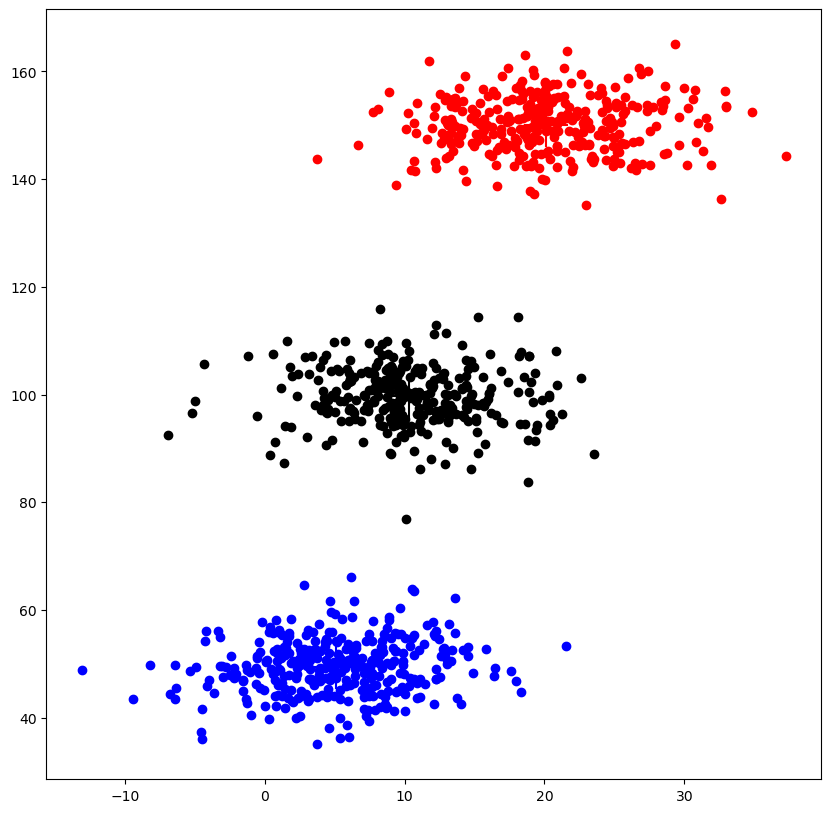

In [73]:
create_cluster_animation(X_train, history, scores)


In [39]:
print(50*50)

2500
